In [3]:
from sources import *
from analysis import *

Auction scandata loaded and cleaned. 30287 records, last updated 2020-04-17 19:34:19 by 396255466#1
Auction scandata full repository. 681880 records with 25 snapshots. Repository has *not* been updated this run
Auction actions full repository. 18840 records
Inventory formatted. 353 records, 1419 total money across chars
Inventory full repository. 13496 records with 34 snapshots. Repository has  been updated this run
Item prices calculated. 11416 records


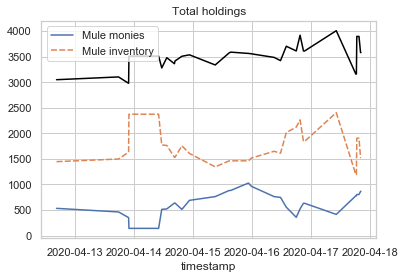

In [4]:
v = True
generate_auction_scandata(verbose=v)
generate_auction_activity(verbose=v)
generate_inventory(verbose=v)
analyse_item_prices(verbose=v)
analyse_sales_performance()

## Sell modes

* Short term quick sell downs, just under price, right # of items, not below reserve price
* Med term, once in morning once in evening
* Longer term high value, make sure market doesnt empty, beat others doing it

In [124]:
# auction_scandata = pd.read_parquet('full/auction_scandata.parquet')
# auction_scandata = auction_scandata[auction_scandata['price_per']!=0]

# auction_scandata['weight_time'] = ((auction_scandata['timestamp'] - auction_scandata['timestamp'].min()) / (auction_scandata['timestamp'].max() - auction_scandata['timestamp'].min())) + 0.1

# auction_scandata = auction_scandata[auction_scandata['item']=='Plaguebloom']
# auction_scandata = auction_scandata.sample(frac=1, weights='weight_time', replace=True)
# auction_scandata

In [ ]:
generate_market_average_prices()
generate_item_sell_prices()
prices = pd.read_parquet('intermediate/sell_prices.parquet')
pd.DataFrame(prices['min_list_price']/10000)

In [ ]:
prices = pd.read_parquet('intermediate/sell_prices.parquet')

In [ ]:
prices[['gross_profit', 'auction_success']].dropna()

In [ ]:
prices['ingredient_value'] = prices['gross_profit'] * prices['auction_success']

In [ ]:
user_items = load_items()

In [ ]:
ingredient_df = pd.DataFrame()
for item, details in user_items.items():
    if details.get('made_from'):
        for ingredient, count in details.get('made_from').items():
            ingredient_df.loc[item, ingredient] = count
        
# xs = ingredient_df.drop(['Crystal Vial', 'Leaded Vial', 'Empty Vial'], axis=1).fillna(0).astype(int)
# ys = ingredient_raw['ingredient_value']

In [ ]:
ingredient_raw

In [ ]:
def update_beta(pred_beta, y, x, learning_rate=0.02):
    actual_value = y * (x / x.sum())
    actual_value = actual_value[actual_value>0]

    new_beta = pred_beta.copy()
    new_beta.update(actual_value)

    # Introduce some truthiness to the betas
    pred_beta += ((new_beta - pred_beta) * learning_rate)
    return pred_beta

In [ ]:
import numpy as np

In [ ]:
random_start = ((np.random.rand(len(xs.columns)) - 0.5) + 1) * ys.mean()

In [ ]:
pred_beta = pd.Series(random_start, index=xs.columns)

In [ ]:
all_betas = pd.DataFrame(columns=pred_beta.index)

for i in range(800):
    for item, y in ys.sample(10).items():
        x = xs.loc[item]
        pred_beta = update_beta(pred_beta, y, x, learning_rate=0.005)
        
        if verbose:
            beta_proportion = ((pred_beta / pred_beta.sum()))
            all_betas.loc[i] = beta_proportion
if verbose:
    all_betas.plot(legend=False)
            
beta_proportion = ((pred_beta / pred_beta.sum()))            
beta_proportion.sort_values()         

In [ ]:
pred_beta

In [ ]:
# Need a POPULARITY metric, something that signifies how many of the last x auctions have been item

In [ ]:
def analyse_stocktake_value(excluded_characters=[]):
    df = pd.read_parquet('intermediate/inventory.parquet')

    item_count = df.groupby('item')['count'].sum()
    items = load_items()
    # Adjust for self demand
    for item, detail in items.items():
        if 'self_demand' in detail:
            for character, count in detail['self_demand'].items():
                if character not in excluded_characters:
                    if item in item_count.index:
                        item_count.loc[item] -= count

    ####

    # Get prices from below
    prices.name = 'price'
    stocktake = pd.DataFrame(item_count).join(prices)
    stocktake['est'] = stocktake['count'] * stocktake['price']
    print(int(stocktake['est'].sum() / 10000))                
    
    
analyse_stocktake_value(excluded_characters=['Amazoni'])    